<a href="https://colab.research.google.com/github/ale22toni/ISPC-Ciencia-de-Datos/blob/main/Examan_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consignas:
Analizar y resolver
Subir a repositorio de Github, con al menos un pull request, y devolver el link
1- Generar un set de datos, con al menos 4 predictores

2- Dado el siguiente código indicar que tipo de problema instanta resolver.

3- Evaluar los resultados.

4- Agregar otro algoritmo para resolver sobre el mismo set de datos.

In [1]:
#pip install pydataset


In [2]:
#pip install tensorflow

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime

# Gráficos
# ==============================================================================
import seaborn as sns
# Apply the default theme
sns.set_theme()

# Preprocesado y modelado
# ==============================================================================
from sklearn import datasets
from pydataset import data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import statsmodels.api as sm

import tensorflow as tf

# Configuración matplotlib
# ==============================================================================
from matplotlib import pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.simplefilter("ignore")
    
pd.options.display.max_columns = None
pd.options.display.max_rows = None



Regresión lineal
Para generar los datos usaremos las funciones provistas en sklearn
sklearn.datasets: Datasets

In [4]:
# Datos

diabetes_data = datasets.load_diabetes()
datos = pd.DataFrame(diabetes_data.data,columns=diabetes_data.feature_names)
datos['target'] = pd.Series(diabetes_data.target)
datos.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
datos.shape


(442, 11)

In [6]:
datos.columns


Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [8]:
# Correlación entre columnas numéricas

X = datos.drop(columns = 'target')
y = datos['target']

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = X.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
54,s2,s1,0.896663,0.896663
45,s1,s2,0.896663,0.896663
67,s3,s4,-0.738493,0.738493
76,s4,s3,-0.738493,0.738493
57,s2,s4,0.659817,0.659817
75,s4,s2,0.659817,0.659817
78,s4,s5,0.617857,0.617857
87,s5,s4,0.617857,0.617857
74,s4,s1,0.542207,0.542207
47,s1,s4,0.542207,0.542207


In [14]:
import matplotlib.pyplot as plt

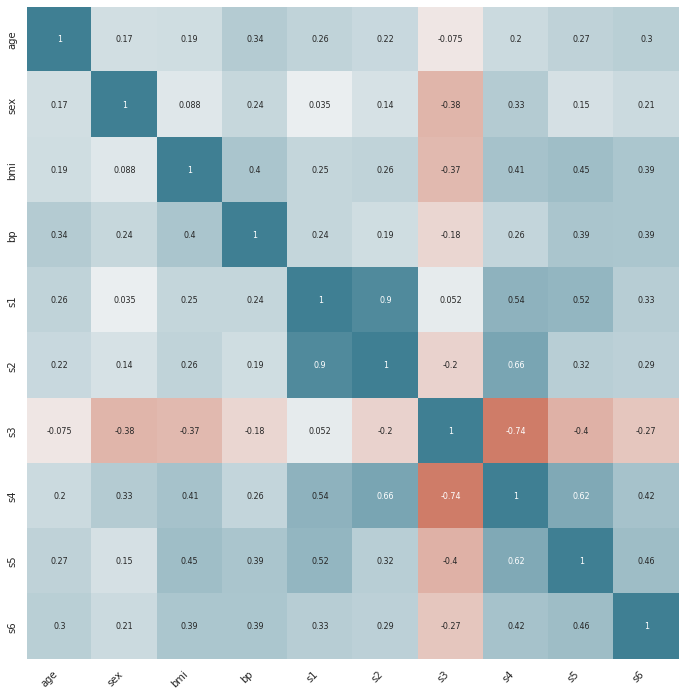

In [15]:
# Heatmap matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

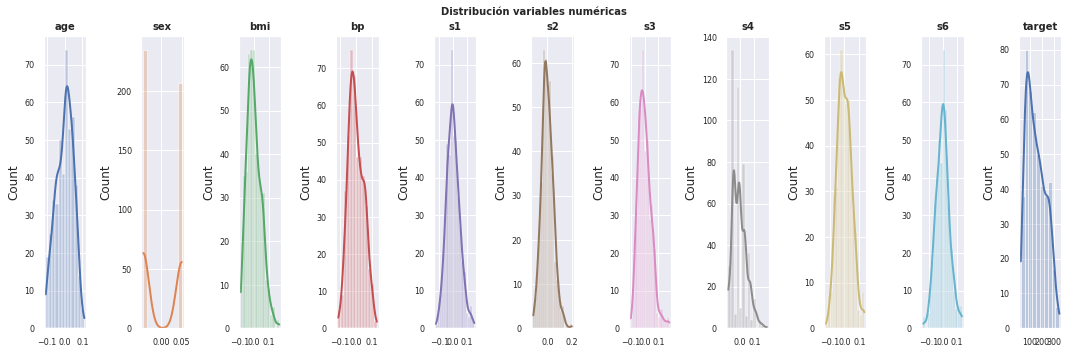

In [16]:
# Gráfico de distribución para cada variable numérica

fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(15, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");


In [17]:
datos.columns


Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

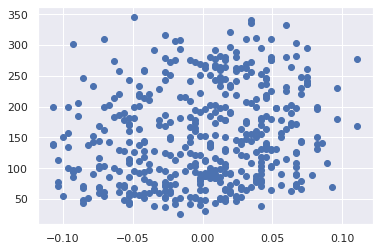

In [18]:
plt.scatter(datos['age'],datos['target'])

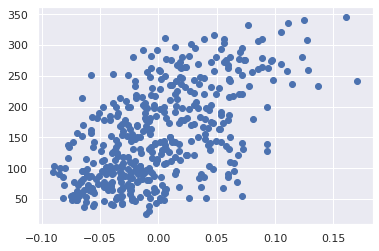

In [19]:
plt.scatter(datos['bmi'],datos['target'])


In [20]:
# FUNCION DE DIAGNOSTICOS DE RESIDUOS y GRAFICOS
def diagnostic_garbages(y_train, prediccion_train,residuos_train ):
  ''' 
  Se reciben los siguientes parametros
  y_train = vector de salida de entrenamiento
  prediccion_train =  resultado de diagnostico de errores
  residuos_train = resultado de diagnostico de errores
  '''
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

  axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                  'k--', color = 'black', lw=2)
  axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
  axes[0, 0].set_xlabel('Real')
  axes[0, 0].set_ylabel('Predicción')
  axes[0, 0].tick_params(labelsize = 7)

  axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[0, 1].set_xlabel('id')
  axes[0, 1].set_ylabel('Residuo')
  axes[0, 1].tick_params(labelsize = 7)

  sns.histplot(
      data    = residuos_train,
      stat    = "density",
      kde     = True,
      line_kws= {'linewidth': 1},
      color   = "firebrick",
      alpha   = 0.3,
      ax      = axes[1, 0]
  )

  axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                      fontweight = "bold")
  axes[1, 0].set_xlabel("Residuo")
  axes[1, 0].tick_params(labelsize = 7)


  sm.qqplot(
      residuos_train,
      fit   = True,
      line  = 'q',
      ax    = axes[1, 1], 
      color = 'firebrick',
      alpha = 0.4,
      lw    = 2
  )
  axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[1, 1].tick_params(labelsize = 7)

  axes[2, 0].scatter(prediccion_train, residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
  axes[2, 0].set_xlabel('Predicción')
  axes[2, 0].set_ylabel('Residuo')
  axes[2, 0].tick_params(labelsize = 7)

  # Se eliminan los axes vacíos
  fig.delaxes(axes[2,1])

  fig.tight_layout()
  plt.subplots_adjust(top=0.9)
  fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [31]:
! pip install statsmodels



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# División de los datos en train y test
# ==============================================================================
X = datos[['age', 'sex', 'bmi', 'bp', 's1']]
y = datos['target']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y.values.reshape(-1,1),
                                                    train_size   = 0.8,
                                                    random_state = 1234,
                                                    shuffle      = True
                                                    )